In [132]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import bson
import base64
import os
import tqdm

In [156]:
# Constants
IMAGES_FOLDER = "data/images"
MAX_RECORD = 50000

## Read the BSON file and create a Pandas DataFrame out of it

In [157]:
categories_df = pd.read_csv("data/category_names.csv")
data = bson.decode_file_iter(open("data/train.bson", "rb"))

In [158]:
def encode_b64(data) :
    encoded = base64.b64encode(data)
    return encoded

def create_dataframe(data_gen) :
    ids = []
    category_ids = []
    imgs = []
    i=0
    counter = 0
    
    for c, d in enumerate(data_gen):
        i += 1
        
        if (i % (MAX_RECORD/10)) == 0:
            counter += 10
            print(str(counter) + "%")
        
        if i > MAX_RECORD:
            break
        product_id = d["_id"]
        category_id = d["category_id"]
        for img_dict in d["imgs"]:
            img = encode_b64(img_dict["picture"])
        
            ids.append(product_id)
            category_ids.append(category_id)
            imgs.append(img)
    return pd.DataFrame({"_id":ids, "category_id":category_ids, "picture":imgs})

In [159]:
df = create_dataframe(data)

**The data contained in the BSON file has been extracted in a Pandas DataFrame**

In [137]:
df.head(5)

,_id,category_id,picture
0,0,1000010653,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,1,1000010653,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
2,2,1000004079,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
3,3,1000004141,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
4,4,1000015539,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


## Exploration

The data is read with pandas from the csv that we extracted from the BSON file

In [138]:
def decode(data):
    arr = np.asarray(bytearray(data), dtype=np.uint8)
    img = cv2.imdecode(arr, cv2.IMREAD_COLOR)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

In [139]:
df.head()

,_id,category_id,picture
0,0,1000010653,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,1,1000010653,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
2,2,1000004079,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
3,3,1000004141,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
4,4,1000015539,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


In [140]:
df.iloc[0]

_id                                                            0
category_id                                           1000010653
picture        /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
Name: 0, dtype: object

In [150]:
print("Unique categories: ", len(categories_df['category_id'].unique()))
print("Unique level 1 categories: ", len(categories_df['category_level1'].unique()))
print("Unique level 2 categories: ", len(categories_df['category_level2'].unique()))
print("Unique level 3 categories: ", len(categories_df['category_level3'].unique()))

Unique categories:  5270
Unique level 1 categories:  49
Unique level 2 categories:  483
Unique level 3 categories:  5263


### Categories levels
There three levels of categories. The first level being more generic (less number of different categories) and the thrid level being more specific (higher number of different categories)

In [143]:
for level in range(1, 4):   
    num_category = len(categories_df['category_level' + str(level)].unique())
    print("Number of categories for the level {}: {}".format(str(level), str(num_category)))

Number of categories for the level 1: 49
Number of categories for the level 2: 483
Number of categories for the level 3: 5263


We can visualize the categories levels for the level 1 being ELECTRONIQUE. We can clearly see that for one level 1 category, there are a high number of level 3 categories

In [144]:
categories_df[categories_df["category_level1"] == "ELECTRONIQUE"].head(8)

,category_id,category_level1,category_level2,category_level3
2110,1000013222,ELECTRONIQUE,AUTOMATISME,AUTOMATE PROGRAMMABLE
2111,1000013224,ELECTRONIQUE,AUTOMATISME,C-CONTROL
2112,1000013228,ELECTRONIQUE,AUTOMATISME,MAINTENANCE A DISTANCE
2113,1000013230,ELECTRONIQUE,AUTOMATISME,MESURE ET REGULATION
2114,1000013232,ELECTRONIQUE,AUTOMATISME,MOTORISATION
2115,1000013234,ELECTRONIQUE,AUTOMATISME,SIGNALISATION
2116,1000013237,ELECTRONIQUE,BOITIERS ET COFFRETS,ACCESSOIRES BOITIERS
2117,1000013239,ELECTRONIQUE,BOITIERS ET COFFRETS,BOITIER D'INSTALLATION MURAL


In [145]:
keep_columns = ["picture", "category_level1"]
imgs_with_labels = df.merge(categories_df, left_on="category_id", right_on="category_id")[keep_columns]
imgs_with_labels.to_csv("data/imgs_with_labels.csv")

**We will focus on the first level for our image classifer**

### Keeping categories having enough images

We do a groupby to count the number of images we have for each category

In [146]:
df_count = imgs_with_labels.groupby(['category_level1'])['picture'].count()
df_category_count = pd.DataFrame(df_count)
df_category_count.columns = ["images_count"]
df_category_count.head(10)

,images_count
category_level1,
ARTICLES POUR FUMEUR,1
AUTO - MOTO,9
BAGAGERIE,1
BRICOLAGE - OUTILLAGE - QUINCAILLERIE,5
DECO - LINGE - LUMINAIRE,7
ELECTROMENAGER,3
INFORMATIQUE,12
LIBRAIRIE,5
LOISIRS CREATIFS - BEAUX ARTS - PAPETERIE,1


Text(0.5, 1.0, 'Data distribution of images per category')

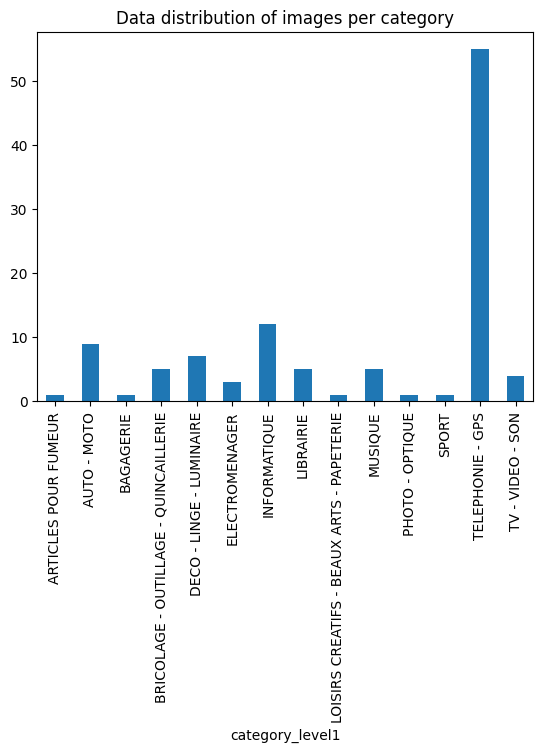

In [160]:
df_count.plot(kind = 'bar')
plt.title("Data distribution of images per category")

## Creating the image data

### Creating ID folders

In [147]:
def create_category_id_folders(list_category_id, img_folder) :
    make_folder_if_not_exist(img_folder)
    for cat_id in list_category_id :
        dest_path = os.path.join(img_folder,str(cat_id))
        make_folder_if_not_exist(dest_path)
        
def make_folder_if_not_exist(img_folder):
    if not os.path.exists(img_folder):
        os.mkdir(img_folder)
        
categories = list(imgs_with_labels["category_level1"].unique())
    
create_category_id_folders(categories, IMAGES_FOLDER)

### Export images from their binary representation in their respective folders

In [148]:
def write_images_to_category_folder(data, img_folder) :
    i = 0
    counter = 0
    
    # For each row in the dataframe
    for j, d in imgs_with_labels.iterrows() :
        
        if (i % (MAX_RECORD/10)) == 0:
            counter += 10
            print(str(counter) + "%")
            
        dest_path = os.path.join(img_folder,str(d['category_level1']),str(d['category_level1'])+'_'+str(i)+'.jpg')
        image = d['picture']
        with open(dest_path, 'wb') as f:
            f.write(image)
            i+=1
            
write_images_to_category_folder(imgs_with_labels, IMAGES_FOLDER)

10%
20%
30%
40%
50%
60%
70%
80%
90%
100%
110%
